# Segmentez des clients d'un site e-commerce - *Notebook essais*

In [21]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn

from sklearn.impute import KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn import datasets
from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

import timeit
import warnings

# pour cartographie
import folium
import cartopy.crs as ccrs
import geopandas as gpd
import contextily as ctx

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)

print("folium version", folium.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
folium version 0.19.2


## Elaborer un modèle de clustering

Chargeons le dataset généré lors de l'exploration

In [22]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_5/data_projet/cleaned/data_olist_cleaned.csv", sep=',', low_memory=False)
data.head()

,latitude,longitude,nb_jours_anciennete,recence,frequence,montant,nb_jours_entre_chaque_commande,score_moyen,nb_notes,montant_norm,recence_norm,frequence_norm
0,-23.606033,-46.637242,519,57,17,729.62,30.573540,4.764706,17.0,2.083949,-2.365248,5.199338
1,-24.000695,-46.394515,393,231,9,1000.85,28.138743,2.777778,9.0,2.359068,-0.236799,5.199338
2,-18.946711,-49.451508,338,245,7,809.21,37.559075,5.000000,7.0,2.174590,-0.143512,5.199338
3,-23.948291,-46.325421,393,111,7,664.20,43.742868,5.000000,7.0,2.022140,-1.102440,5.199338
4,-8.121023,-34.896307,373,138,7,806.61,31.100443,5.000000,7.0,2.173204,-0.873515,5.199338


In [90]:
data.shape

(96096, 12)

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        95828 non-null  float64
 1   longitude                       95828 non-null  float64
 2   nb_jours_anciennete             96096 non-null  int64  
 3   recence                         96096 non-null  int64  
 4   frequence                       96096 non-null  int64  
 5   montant                         96096 non-null  float64
 6   nb_jours_entre_chaque_commande  96096 non-null  float64
 7   score_moyen                     96096 non-null  float64
 8   nb_notes                        96096 non-null  float64
 9   montant_norm                    96096 non-null  float64
 10  recence_norm                    96096 non-null  float64
 11  frequence_norm                  96096 non-null  float64
dtypes: float64(9), int64(3)
memory u

### 1 - essai n°1 - features RFM avec K-means

Il s'agit ici d'utilser les 3 features RFM (recence, frequence et montant) pour un premier clustering avec l'algorithme k-means.

#### 1.1 - Filtrage des 3 features

Dataframe pour l'entraînement et les prédictions :

In [175]:
X_1 = data[['recence_norm', 'frequence_norm', 'montant_norm']].copy()
X_1.shape

(96096, 3)

In [98]:
X_1.describe()

,recence_norm,frequence_norm,montant_norm
count,96096.000000,96096.000000,96096.000000
mean,-0.005261,-4.969655,-0.009231
std,1.007897,1.281230,1.002558
min,-5.199338,-5.199338,-5.199338
25%,-0.689529,-5.199338,-0.689847
50%,-0.011291,-5.199338,0.002509
75%,0.689529,-5.199338,0.657615
max,5.199338,5.199338,5.199338


Dataframe pour l'analyse :

In [100]:
data_1 = data[['recence', 'frequence', 'montant']].copy()

In [102]:
data_1.describe()

,recence,frequence,montant
count,96096.000000,96096.000000,96096.000000
mean,287.735691,1.034809,142.070597
std,153.414676,0.214384,216.933877
min,0.000000,1.000000,0.850000
25%,163.000000,1.000000,47.990000
50%,268.000000,1.000000,89.900000
75%,397.000000,1.000000,154.000000
max,772.000000,17.000000,13440.000000


#### 1.2 - Test k-means

In [11]:
warnings.filterwarnings("ignore")

# Une liste vide pour enregistrer les inerties :  
inertia_list = [ ]
silhouette_avg_list = []

# Notre liste de nombres de clusters : 
k_list = range(2, 8)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, init="k-means++")
    
    # On entraine
    labels = kmeans.fit_predict(X_1)
    
    # On enregistre l'inertie obtenue : 
    inertia_list.append(kmeans.inertia_)
    
    # Calculer le coefficient de silhouette global
    silhouette_avg = silhouette_score(X_1, labels)
    silhouette_avg_list.append(round(silhouette_avg, 2))
    
    # Calculer les coefficients de silhouette pour chaque point
    #silhouette_values = silhouette_samples(X_1, labels)

In [12]:
inertia_list

[192460.30882492953,
 132049.9710761452,
 91658.80785680849,
 73520.81494709275,
 63397.93352002368,
 53402.96333808854]

In [13]:
silhouette_avg_list

[0.77, 0.32, 0.34, 0.33, 0.31, 0.33]

Le coefficient de silhouette prend en compte non seulement la densité des clusters mais aussi l'écart entre les différents clusters.

On voit que le coefficient de silhouette (0,75 proche de 1) est le meilleur pour 2 clusters. Cela signifie que la densité des clusters est bonne et que l'écart est respecté.

On voit ensuite que le coefficient de silhouette décline fortement, au-delà de 2 pour les valeurs de k = 3, 4, 5, et 6. Comme on le verra par la suite, c'est parceque l'écart entre certains clusters est faible.

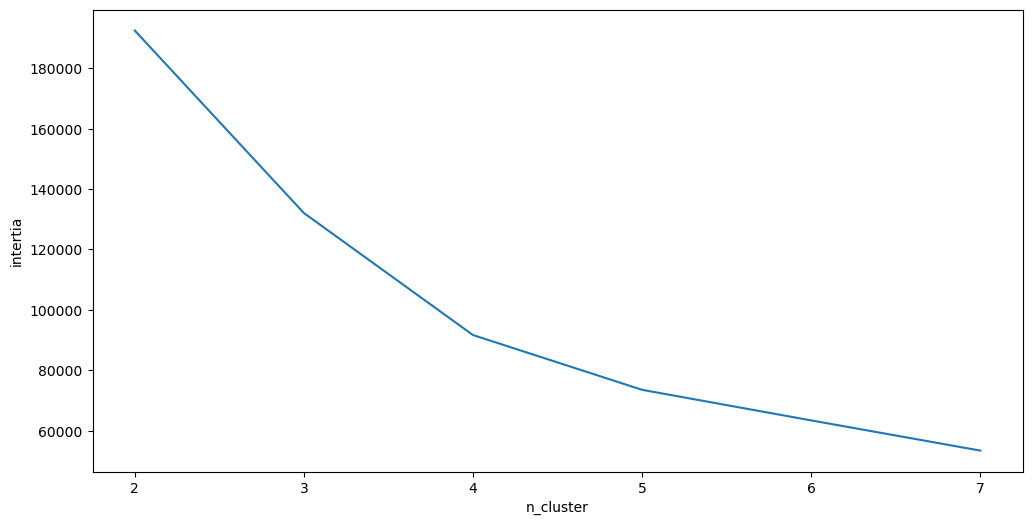

In [15]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list, inertia_list)

Avec la méthode du coude, le nombre de clusters optimal (valeur de k) est de 3 ou 4.

La valeur du coefficient de silhouette permet de partager entre 3 et 4, car le coefficient de silhouette est meilleur avec 4 clusters.

A noter que le coefficient de silhouette est le plus élevé pour 2 clusters, mais 2 clusters n'apporteraient pas grand chose dans la segmentation des clients, où on aurait seulement les clients qui passent le plus de commande, et ceux qui n'en passent qu'une (voir figure plus bas).

In [17]:
# Création du DataFrame
results_df = pd.DataFrame({
    "k": k_list,  # Nombre de clusters
    "Inertia": inertia_list,
    "Silhouette": silhouette_avg_list
})

# Affichage du DataFrame
print(results_df)

   k        Inertia  Silhouette
0  2  192460.308825        0.77
1  3  132049.971076        0.32
2  4   91658.807857        0.34
3  5   73520.814947        0.33
4  6   63397.933520        0.31
5  7   53402.963338        0.33


#### 1.3 - Visualiser le résultat du clustering avec le nombre k de clusters optimal (4) :

**Appliquons le clustering avec k-means et k = 4 :**

In [187]:
# Appliquer le clustering avec le meilleur k (par exemple, k=3)
best_k = 4  # Remplacez par le nombre optimal de clusters choisi
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_1)

# Ajouter les labels aux DataFrames
data_1_with_labels = data_1.copy()
data_1_with_labels["Cluster"] = labels

X_1_with_labels = X_1.copy()
X_1_with_labels["Cluster"] = labels

# Affichage
print(data_1_with_labels.head())

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   recence  frequence  montant  Cluster
0       57         17   729.62        2
1      231          9  1000.85        2
2      245          7   809.21        2
3      111          7   664.20        2
4      138          7   806.61        2


In [189]:
X_1_with_labels.tail()

,recence_norm,frequence_norm,montant_norm,Cluster
96091,1.144896,-5.199338,2.723183,3
96092,0.204660,-5.199338,-0.344236,0
96093,2.196894,-5.199338,0.002509,0
96094,-0.651824,-5.199338,0.287442,1
96095,1.391202,-5.199338,-0.483658,0


In [191]:
X_1_with_labels.shape

(96096, 4)

**Vérifions le nombre de clients dans les 4 clusters :**

Cluster des clients inactifs à faible dépense :

In [193]:
mask = data_1_with_labels['Cluster'] == 0
print("Nombre de clients inactifs à faible dépense (cluster violet) :", data_1_with_labels.loc[mask].shape[0])

Nombre de clients inactifs à faible dépense (cluster violet) : 31916


Cluster des clients récents :

In [112]:
mask = data_1_with_labels['Cluster'] == 1
print("Nombre de clients récents à faible dépense (cluster bleu) :", data_1_with_labels.loc[mask].shape[0])

Nombre de clients récents à faible dépense (cluster bleu) : 31366


Cluster des clients fidèles :

In [195]:
mask = data_1_with_labels['Cluster'] == 2
print("Nombre de clients fidèles (cluster vert) :", data_1_with_labels.loc[mask].shape[0])

Nombre de clients fidèles (cluster vert) : 2997


Ce nombre correspond à tous les clients qui ont fait plusieurs commandes.

Cluster des clients anciens haut de gamme :

In [116]:
mask = data_1_with_labels['Cluster'] == 3
print("Nombre de clients haut de gamme (cluster jaune) :", data_1_with_labels.loc[mask].shape[0])

Nombre de clients haut de gamme (cluster jaune) : 29817


Le nombre de clients par cluster est correct (> 500 individus). Le plus petit est celui des clients qui ont fait plusieurs commandes (2 997).

**Visualisons les boxplots de chaque feature par cluster**

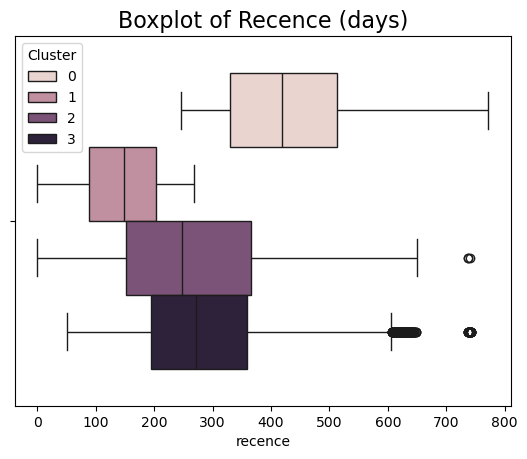

In [123]:
sns.boxplot(data=data_1_with_labels, x='recence', hue='Cluster')
plt.title('Boxplot of Recence (days)', fontsize=16)
plt.show()

On observe que :
- le cluster 0 contient les clients les plus anciens.
- le cluster 1 contient les clients les plus récents.

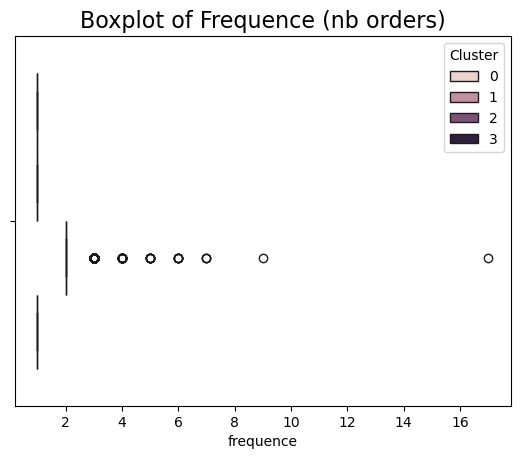

In [125]:
sns.boxplot(data=data_1_with_labels, x='frequence', hue='Cluster')
plt.title('Boxplot of Frequence (nb orders)', fontsize=16)
plt.show()

On observe que le cluster 2 contient les clients ayant passé plusieurs commandes (clients fidèles).

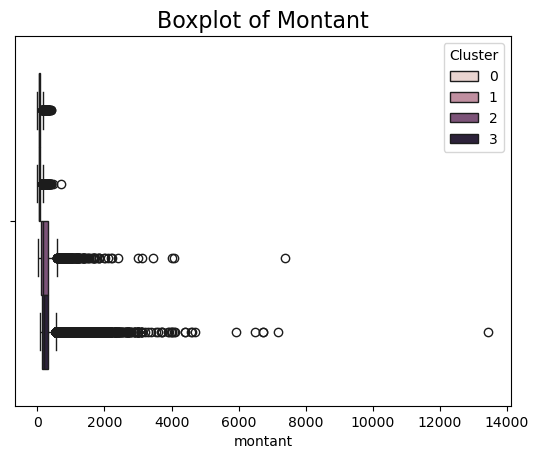

In [127]:
sns.boxplot(data=data_1_with_labels, x='montant', hue='Cluster')
plt.title('Boxplot of Montant', fontsize=16)
plt.show()

On voit que le cluster 3 contient les clients qui ont le cumul de montants le plus élevé.

Sans les montants > 4000 : 

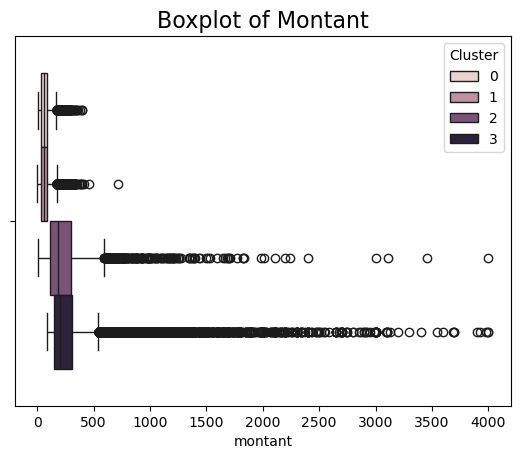

In [133]:
mask = data_1_with_labels['montant'] < 4000
sns.boxplot(data=data_1_with_labels.loc[mask], x='montant', hue='Cluster')
plt.title('Boxplot of Montant', fontsize=16)
plt.show()

**Calculons les moyennes par cluster:**

In [141]:
means = []
for cluster in data_1_with_labels['Cluster'].unique():
    mask = data_1_with_labels['Cluster'] == cluster
    means.append([cluster, data_1_with_labels.loc[mask, 'recence'].mean(), \
                  data_1_with_labels.loc[mask, 'frequence'].mean(), \
                  data_1_with_labels.loc[mask, 'montant'].mean()])
df_means = pd.DataFrame(data=means, columns=['cluster', 'recence moy', 'frequence moy', 'montant moy'])
df_means.head()

,cluster,recence moy,frequence moy,montant moy
0,2,268.206874,2.116116,260.107164
1,3,285.275380,1.000000,293.634989
2,1,148.872888,1.000000,66.801668
3,0,428.337824,1.000000,63.361929


On observe que :
- le cluster 0 contient les clients les plus anciens, ayant passé une seule commande, d'un montant moyen faible ==> **clients inactifs à faible dépense**
- le cluster 1 contient les clients les plus récents, ayant passé une seule commande, d'un montant moyen faible ==> **clients récents à faible dépense**
- le cluster 2 contient des clients anciens, d'une seule commande, mais avec un montant cumulé moyen plus élevé ==> **clients haut de gamme**
- le cluster 3 contient les clients ayant plusieurs commandes, et le montant cumulé moyen se rapproche des clients haut de gamme ==> **clients fidèles**

**Visualisation 2D :**

Pour toutes les visualisation (hors boxplot) j'utiliserai les valeurs normalisées des features, car les figuressont plus expressives, c'està direque les clusters sont mieux mis en évidence.

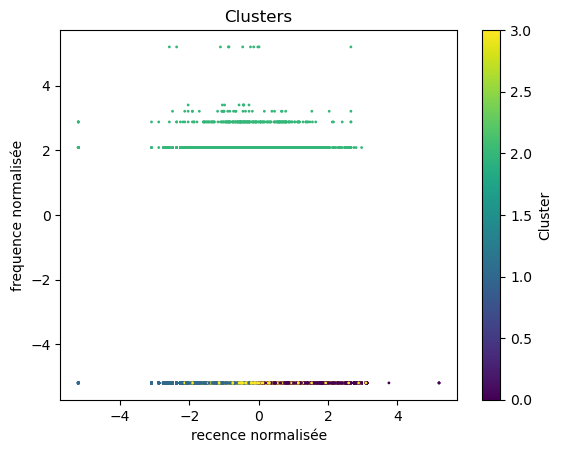

In [199]:
plt.scatter(X_1_with_labels["recence_norm"], X_1_with_labels["frequence_norm"], 
            c=X_1_with_labels["Cluster"], cmap="viridis", s=1)
plt.title("Clusters")
plt.xlabel("recence normalisée")
plt.ylabel("frequence normalisée")
plt.colorbar(label="Cluster")
plt.show()

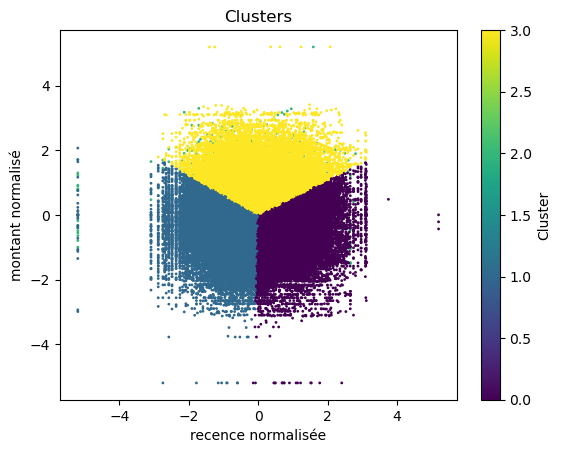

In [201]:
plt.scatter(X_1_with_labels["recence_norm"], X_1_with_labels["montant_norm"], 
            c=X_1_with_labels["Cluster"], cmap="viridis", s=1)
plt.title("Clusters")
plt.xlabel("recence normalisée")
plt.ylabel("montant normalisé")
plt.colorbar(label="Cluster")
plt.show()

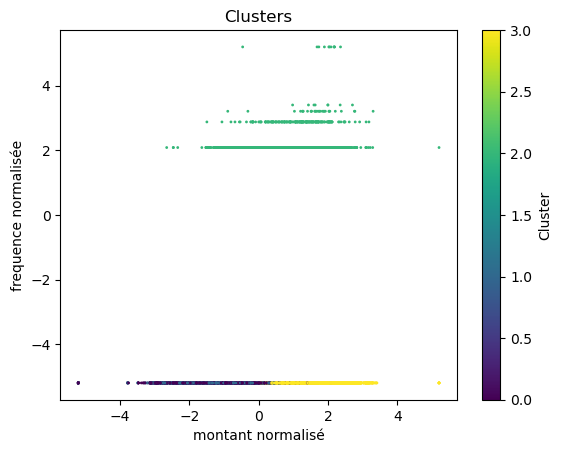

In [203]:
plt.scatter(X_1_with_labels["montant_norm"], X_1_with_labels["frequence_norm"], 
            c=X_1_with_labels["Cluster"], cmap="viridis", s=1)
plt.title("Clusters")
plt.xlabel("montant normalisé")
plt.ylabel("frequence normalisée")
plt.colorbar(label="Cluster")
plt.show()

Visualisation 3D :

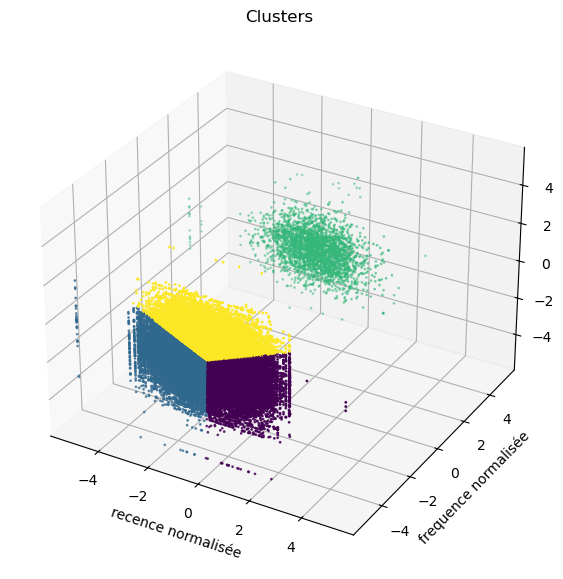

In [205]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_1_with_labels["recence_norm"], X_1_with_labels["frequence_norm"], X_1_with_labels["montant_norm"], 
           c=X_1_with_labels["Cluster"], cmap="viridis", s=1)
ax.set_title("Clusters")
ax.set_xlabel("recence normalisée")
ax.set_ylabel("frequence normalisée")
ax.set_zlabel("montant normalisé")
plt.show()

Les 4 clusters apparaissent clairement sur le schéma. La densité des clusters est correcte, mais l'écart entre les 3 clusters devant est faible.

- cluster vert au fond (Clients fidèles) : regroupe les clients qui ont passé plusieurs commandes
- cluster bleu devant à gauche (Clients récents) : regroupe les clients qui ont passé une commande il n'y a pas longtemps.
- cluster jaune devant en haut (Clients haut de gamme anciens) : regroupe les clients qui ont passé une commande il y a longtemps, et dont le montant de la commande est élevé.
- cluster violet devant en bas (Clients inactifs à faible dépense) : regroupe les clients qui ont passé une commande il y a longtemps, et dont le montant est faible

**Visualisons le résultat du clustering avec 2 clusters :**

In [207]:
# Appliquer le clustering avec 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=42)
labels_2 = kmeans_2.fit_predict(X_1)

# Ajouter les labels aux DataFrames
X_1_with_labels_2 = X_1.copy()
X_1_with_labels_2["Cluster"] = labels_2

data_1_with_labels_2 = data_1.copy()
data_1_with_labels_2["Cluster"] = labels_2

# Affichage
print(X_1_with_labels_2.head())

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   recence_norm  frequence_norm  montant_norm  Cluster
0     -2.365248        5.199338      2.083949        1
1     -0.236799        5.199338      2.359068        1
2     -0.143512        5.199338      2.174590        1
3     -1.102440        5.199338      2.022140        1
4     -0.873515        5.199338      2.173204        1


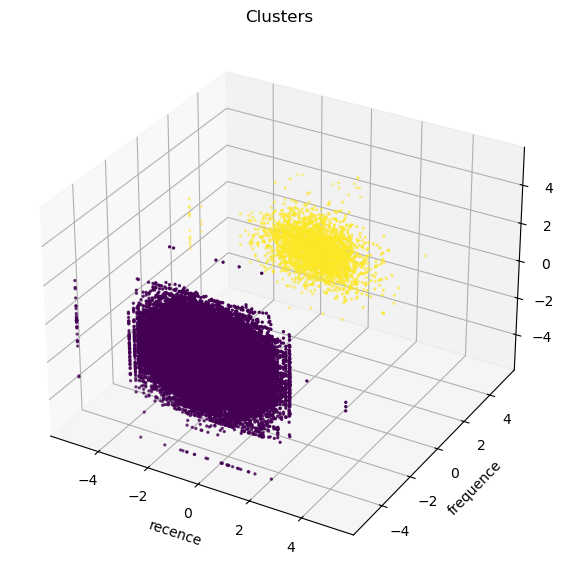

In [209]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_1_with_labels_2["recence_norm"], X_1_with_labels_2["frequence_norm"], X_1_with_labels_2["montant_norm"], 
           c=X_1_with_labels_2["Cluster"], cmap="viridis", s=2)
ax.set_title("Clusters")
ax.set_xlabel("recence")
ax.set_ylabel("frequence")
ax.set_zlabel("montant")
plt.show()

On voit bien l'écart entre les 2 clusters ici : devant les clients avec une commande, derrière les clients fidèles. Mais la séparation en 2 clusters apportent peu de valeurs métiers pour une segmentation clients.

### 2 - essai n°2 - features RFM + scores avec K-means

Il s'agit ici d'utilser les 3 features RFM (recence, frequence et montant) + feature score_moyen, pour un premier clustering avec l'algorithme k-means.

#### 2.1 - Filtrage des 3 features

In [60]:
X_2 = data[['recence_norm', 'frequence_norm', 'montant_norm', 'score_moyen']].copy()
X_2.shape

(96096, 4)

In [62]:
X_2.describe()

,recence_norm,frequence_norm,montant_norm,score_moyen
count,96096.000000,96096.000000,96096.000000,96096.000000
mean,-0.005261,-4.969655,-0.009231,4.091807
std,1.007897,1.281230,1.002558,1.338878
min,-5.199338,-5.199338,-5.199338,1.000000
25%,-0.689529,-5.199338,-0.689847,4.000000
50%,-0.011291,-5.199338,0.002509,5.000000
75%,0.689529,-5.199338,0.657615,5.000000
max,5.199338,5.199338,5.199338,5.000000


In [67]:
data_2 = data[['recence', 'frequence', 'montant', 'score_moyen']].copy()
data_2.shape

(96096, 4)

In [69]:
data_2.describe()

,recence,frequence,montant,score_moyen
count,96096.000000,96096.000000,96096.000000,96096.000000
mean,287.735691,1.034809,142.070597,4.091807
std,153.414676,0.214384,216.933877,1.338878
min,0.000000,1.000000,0.850000,1.000000
25%,163.000000,1.000000,47.990000,4.000000
50%,268.000000,1.000000,89.900000,5.000000
75%,397.000000,1.000000,154.000000,5.000000
max,772.000000,17.000000,13440.000000,5.000000


#### 2.2 - Test K-means

In [71]:
warnings.filterwarnings("ignore")

# Une liste vide pour enregistrer les inerties :  
inertia_list_2 = [ ]
silhouette_avg_list_2 = []

# Notre liste de nombres de clusters : 
k_list_2 = range(2, 8)

# Pour chaque nombre de clusters : 
for k in k_list_2 : 
    
    # On instancie un k-means pour k clusters
    kmeans_2 = KMeans(n_clusters=k, random_state=42, init="k-means++")
    
    # On entraine
    labels_2 = kmeans_2.fit_predict(X_2)
    
    # On enregistre l'inertie obtenue : 
    inertia_list_2.append(kmeans_2.inertia_)
    
    # Calculer le coefficient de silhouette global
    silhouette_avg_2 = silhouette_score(X_2, labels_2)
    silhouette_avg_list_2.append(round(silhouette_avg_2, 2))

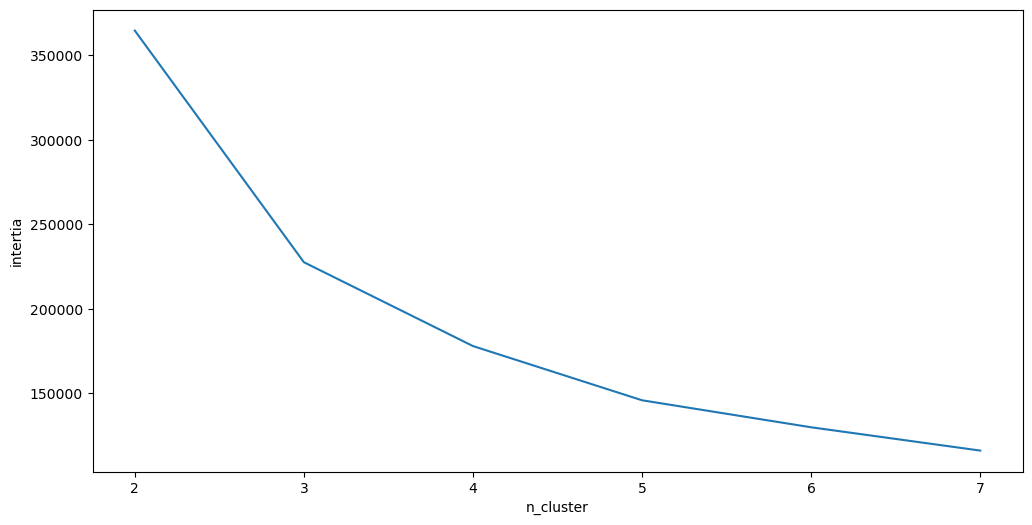

In [72]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list_2, inertia_list_2)

In [75]:
# Création du DataFrame
results_df_2 = pd.DataFrame({
    "k": k_list_2,  # Nombre de clusters
    "Inertia": inertia_list_2,
    "Silhouette": silhouette_avg_list_2
})

# Affichage du DataFrame
print(results_df_2)

   k        Inertia  Silhouette
0  2  364717.478881        0.69
1  3  227480.836845        0.44
2  4  177804.139795        0.31
3  5  145684.552061        0.31
4  6  129687.381606        0.29
5  7  115888.892368        0.29


Le nombre optimal semble être 3 clusters. Il conviendra de regarder la valeur métier que pourront apporter les valeurs 3, 4, et 5 clusters.

#### 2.3 - Visualiser le résultat du clustering avec le nombre k de clusters optimal techniquement (3) :

**Appliquons le clustering avec k-means et k = 3 :**

In [143]:
# Appliquer le clustering avec le meilleur k (par exemple, k=3)
best_k = 3  # Remplacez par le nombre optimal de clusters choisi
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_2)

# Ajouter les labels aux DataFrames
data_2_with_labels = data_2.copy()
data_2_with_labels["Cluster"] = labels

X_2_with_labels = X_2.copy()
X_2_with_labels["Cluster"] = labels

# Affichage
print(data_2_with_labels.head())

   recence  frequence  montant  score_moyen  Cluster
0       57         17   729.62     4.764706        2
1      231          9  1000.85     2.777778        2
2      245          7   809.21     5.000000        2
3      111          7   664.20     5.000000        2
4      138          7   806.61     5.000000        2


In [85]:
X_2_with_labels.shape

(96096, 5)

**Vérifions le nombre de clients dans les 3 clusters :**

In [87]:
mask = data_2_with_labels['Cluster'] == 0
print("Nombre de clients dans le cluster 0 :", data_2_with_labels.loc[mask].shape[0])

mask = data_2_with_labels['Cluster'] == 1
print("Nombre de clients dans le cluster 1 :", data_2_with_labels.loc[mask].shape[0])

mask = data_2_with_labels['Cluster'] == 2
print("Nombre de clients dans le cluster 2 :", data_2_with_labels.loc[mask].shape[0])

Nombre de clients dans le cluster 0 : 21215
Nombre de clients dans le cluster 1 : 71884
Nombre de clients dans le cluster 2 : 2997


On observe que le cluster 1 contient plus de 70 % des clients. La répartition des clients entre les clusters n'est pas optimale.

**Visualisons les boxplots de chaque feature par cluster**

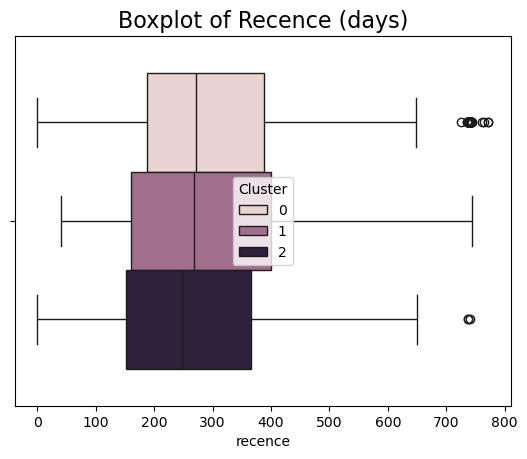

In [90]:
sns.boxplot(data=data_2_with_labels, x='recence', hue='Cluster')
plt.title('Boxplot of Recence (days)', fontsize=16)
plt.show()

La séparation des clusters sur cette feature n'est pas nette.

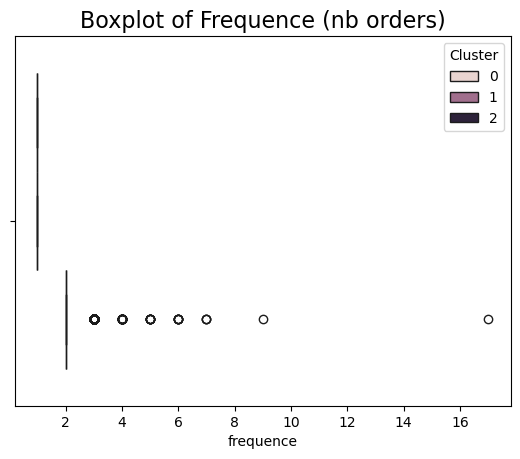

In [92]:
sns.boxplot(data=data_2_with_labels, x='frequence', hue='Cluster')
plt.title('Boxplot of Frequence (nb orders)', fontsize=16)
plt.show()

On observe que le cluster 2 contient les clients avec plusieurs commandes.

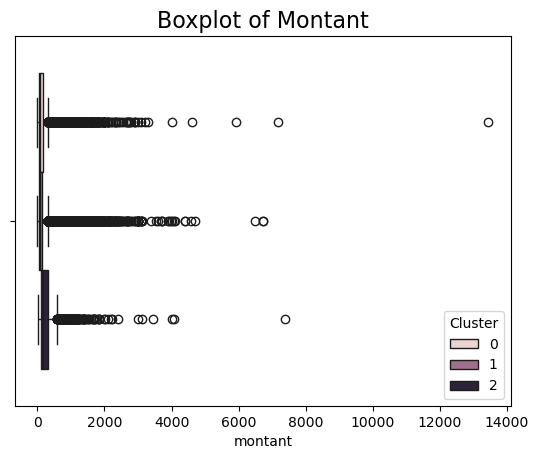

In [94]:
sns.boxplot(data=data_2_with_labels, x='montant', hue='Cluster')
plt.title('Boxplot of Montant', fontsize=16)
plt.show()

La séparation des clusters sur cette feature n'est pas nette.

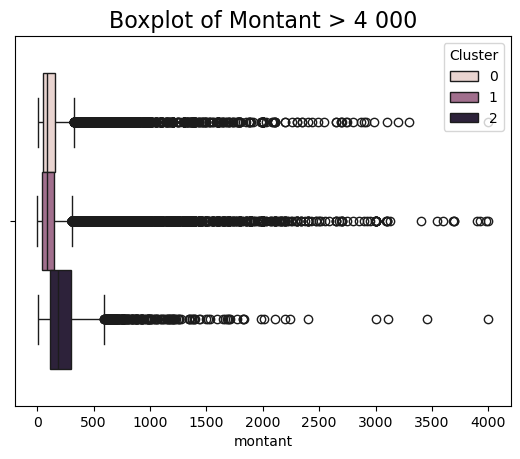

In [96]:
mask = data_2_with_labels['montant'] < 4000
sns.boxplot(data=data_2_with_labels.loc[mask], x='montant', hue='Cluster')
plt.title('Boxplot of Montant > 4 000', fontsize=16)
plt.show()

La séparation des clusters sur cette feature n'est pas franche.

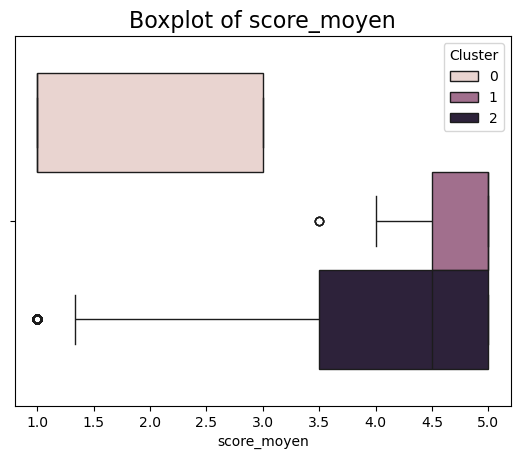

In [98]:
sns.boxplot(data=data_2_with_labels, x='score_moyen', hue='Cluster')
plt.title('Boxplot of score_moyen', fontsize=16)
plt.show()

On observe que le cluster 0 contient les clients qui ont tendance à mettre une note faible.

**Calculons les moyennes par cluster:**

In [101]:
means = []
for cluster in data_2_with_labels['Cluster'].unique():
    mask = data_2_with_labels['Cluster'] == cluster
    means.append([cluster, data_2_with_labels.loc[mask, 'recence'].mean(), \
                  data_2_with_labels.loc[mask, 'frequence'].mean(), \
                  data_2_with_labels.loc[mask, 'montant'].mean(), \
                  data_2_with_labels.loc[mask, 'score_moyen'].mean()])
df_means = pd.DataFrame(data=means, columns=['cluster', 'recence moy', 'frequence moy', 'montant moy', 'score_moyen moy'])
df_means.head()

,cluster,recence moy,frequence moy,montant moy,score_moyen moy
0,2,268.206874,2.116116,260.107164,4.118883
1,1,286.301541,1.000000,135.227950,4.749986
2,0,295.353901,1.000000,148.581144,1.857836


On observe que :
- le cluster 2 contient les clients fidèles avec plusieurs commandes
- le cluster 1 contient les clients avec une seule commande, mais qui ont mis une bonne note
- le cluster 0 contient les clients qui ont mis une mauvaise note.

**Visualisation 2D :**

Pour toutes les visualisations (hors boxplot) j'utiliserai les valeurs normalisées des features, car les figures sont plus expressives, c'est à dire que les clusters sont mieux mis en évidence.

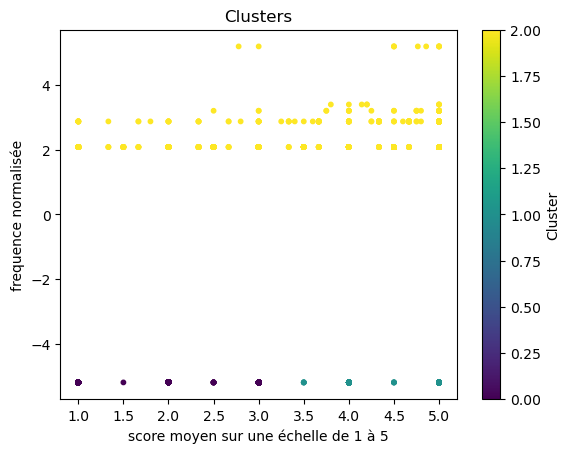

In [162]:
plt.scatter(X_2_with_labels["score_moyen"], X_2_with_labels["frequence_norm"], 
            c=X_2_with_labels["Cluster"], cmap="viridis", s=10)
plt.title("Clusters")
plt.xlabel("score moyen sur une échelle de 1 à 5")
plt.ylabel("frequence normalisée")
plt.colorbar(label="Cluster")
plt.show()

On visualise clairement la séparation des 3 clusters :
- Cluster jaune : clients fidèles avec plusieurs commandes, plus ou moins satisfaits.
- Cluster violet : clients avec une seule commande, plutôt mécontents.
- Cluster vert : clients satisfaits avec une seule commande.

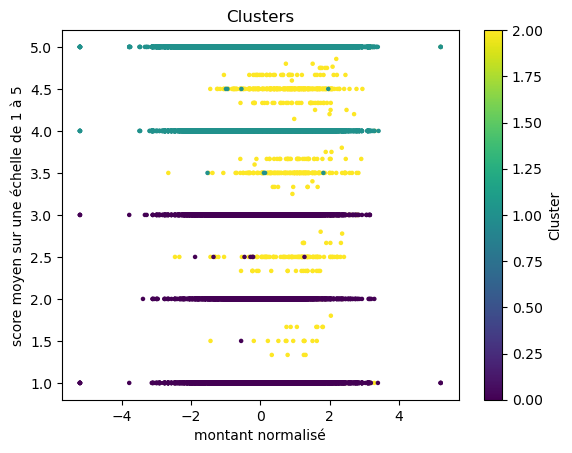

In [158]:
plt.scatter(X_2_with_labels["montant_norm"], X_2_with_labels["score_moyen"], 
            c=X_2_with_labels["Cluster"], cmap="viridis", s=5)
plt.title("Clusters")
plt.xlabel("montant normalisé")
plt.ylabel("score moyen sur une échelle de 1 à 5")
plt.colorbar(label="Cluster")
plt.show()

On observe que :
- Le cluster jaune (2) couvre toute la surface de la figure, comme un fond difus. Mais il semble y a avoir plus de clients dans la partie haute, avec des scores moyens plus élevés. Ce qui peut paraître normal, car s'ils ont passé plusieurs commandes, c'est qu'ils sont satisfait.
- Le cluster violet couvre la partie basse (score inférieur ou égal à 3), quelque soit la valeur du cumul des montants.
- Le cluster vert couvre la partie haute (score > 3), quelque soit la valeur du cumul des montants.

**Visualisation 3D :**

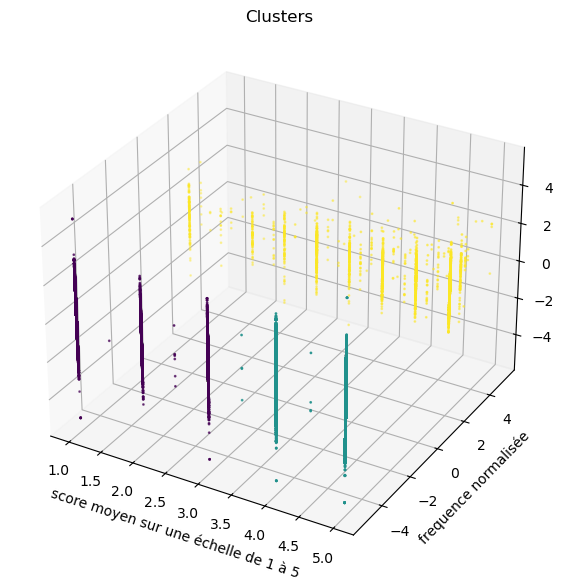

In [156]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_2_with_labels["score_moyen"], X_2_with_labels["frequence_norm"], X_2_with_labels["montant_norm"], 
           c=X_2_with_labels["Cluster"], cmap="viridis", s=1)
ax.set_title("Clusters")
ax.set_xlabel("score moyen sur une échelle de 1 à 5")
ax.set_ylabel("frequence normalisée")
ax.set_zlabel("montant normalisé")
plt.show()

On visualise clairement la séparation des 3 clusters :
- Cluster jaune : clients fidèles avec plusieurs commandes, plus ou moins satisfaits.
- Cluster violet : clients avec une seule commande, plutôt mécontents.
- Cluster vert : clients satisfaits avec une seule commande.

*On constate que le cumul des montants et la récence n'intervient pas dans la séparation en 3 clusters.*

#### 2.4 - Visualiser le résultat du clustering avec le nombre k de clusters optimal (4) :

**Appliquons le clustering avec k-means et k = 4 :**

In [166]:
# Appliquer le clustering avec le meilleur k (par exemple, k=3)
best_k = 4  # Remplacez par le nombre optimal de clusters choisi
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_2)

# Ajouter les labels aux DataFrames
data_2_with_labels = data_2.copy()
data_2_with_labels["Cluster"] = labels

X_2_with_labels = X_2.copy()
X_2_with_labels["Cluster"] = labels

# Affichage
print(data_2_with_labels.head())

   recence  frequence  montant  score_moyen  Cluster
0       57         17   729.62     4.764706        2
1      231          9  1000.85     2.777778        2
2      245          7   809.21     5.000000        2
3      111          7   664.20     5.000000        2
4      138          7   806.61     5.000000        2


**Vérifions le nombre de clients dans les 4 clusters :**

In [168]:
mask = data_2_with_labels['Cluster'] == 0
print("Nombre de clients dans le cluster 0 :", data_2_with_labels.loc[mask].shape[0])

mask = data_2_with_labels['Cluster'] == 1
print("Nombre de clients dans le cluster 1 :", data_2_with_labels.loc[mask].shape[0])

mask = data_2_with_labels['Cluster'] == 2
print("Nombre de clients dans le cluster 2 :", data_2_with_labels.loc[mask].shape[0])

mask = data_2_with_labels['Cluster'] == 3
print("Nombre de clients dans le cluster 3 :", data_2_with_labels.loc[mask].shape[0])

Nombre de clients dans le cluster 0 : 37671
Nombre de clients dans le cluster 1 : 19731
Nombre de clients dans le cluster 2 : 2997
Nombre de clients dans le cluster 3 : 35697


**Calculons les moyennes par cluster:**

In [170]:
means = []
for cluster in data_2_with_labels['Cluster'].unique():
    mask = data_2_with_labels['Cluster'] == cluster
    means.append([cluster, data_2_with_labels.loc[mask, 'recence'].mean(), \
                  data_2_with_labels.loc[mask, 'frequence'].mean(), \
                  data_2_with_labels.loc[mask, 'montant'].mean(), \
                  data_2_with_labels.loc[mask, 'score_moyen'].mean()])
df_means = pd.DataFrame(data=means, columns=['cluster', 'recence moy', 'frequence moy', 'montant moy', 'score_moyen moy'])
df_means.head()

,cluster,recence moy,frequence moy,montant moy,score_moyen moy
0,2,268.206874,2.116116,260.107164,4.118883
1,3,152.009385,1.000000,136.233962,4.714388
2,0,414.187970,1.000000,132.711898,4.714754
3,1,294.829406,1.000000,152.569118,1.771983


On observe que :
- le cluster 2 contient les clients fidèles avec plusieurs commandes
- le cluster 3 contient les clients récents avec une seule commande.
- le cluster 0 contient les clients anciens satisfaits, avec une seule commande.
- le cluster 1 contient les clients avec une seule commande non satisfaits

*Le cumul des montants ne semblent pas intervenir dans la séparation en 4 clusters.*

**Visualisons les boxplots de chaque feature par cluster**

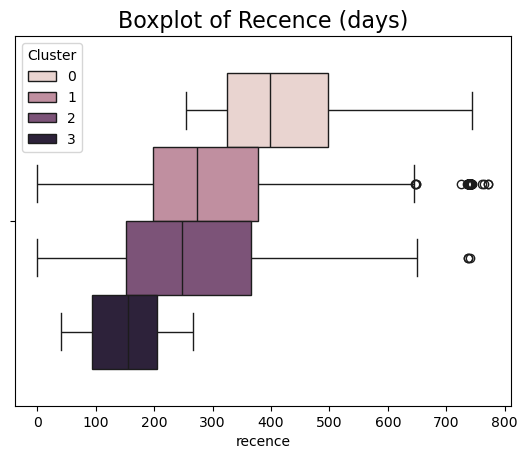

In [113]:
sns.boxplot(data=data_2_with_labels, x='recence', hue='Cluster')
plt.title('Boxplot of Recence (days)', fontsize=16)
plt.show()

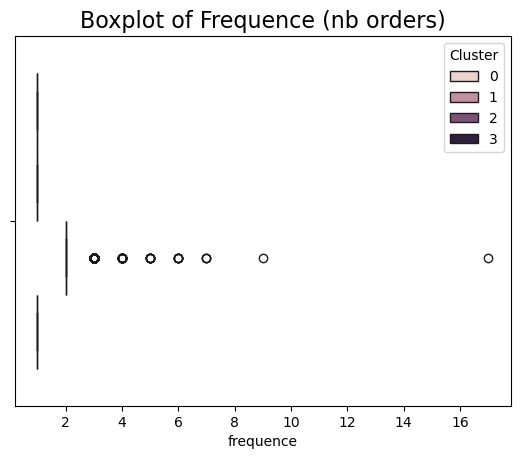

In [115]:
sns.boxplot(data=data_2_with_labels, x='frequence', hue='Cluster')
plt.title('Boxplot of Frequence (nb orders)', fontsize=16)
plt.show()

Le cluster 3 correspond aux clients avec plusieurs commandes.

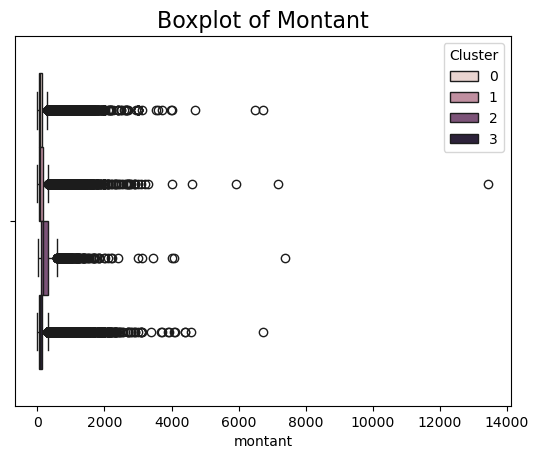

In [117]:
sns.boxplot(data=data_2_with_labels, x='montant', hue='Cluster')
plt.title('Boxplot of Montant', fontsize=16)
plt.show()

On voit clairement ici que le cumul des montants n'intervient pas dans la clusterisation.

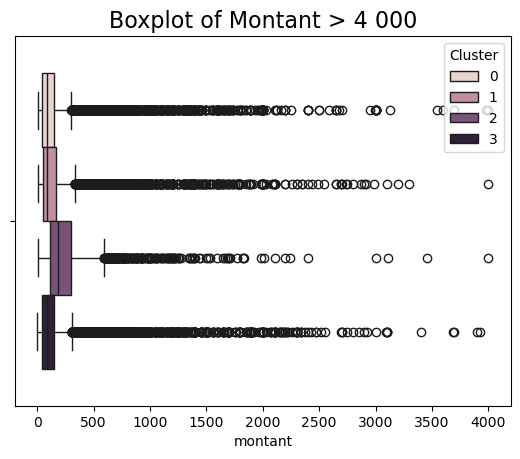

In [119]:
mask = data_2_with_labels['montant'] < 4000
sns.boxplot(data=data_2_with_labels.loc[mask], x='montant', hue='Cluster')
plt.title('Boxplot of Montant > 4 000', fontsize=16)
plt.show()

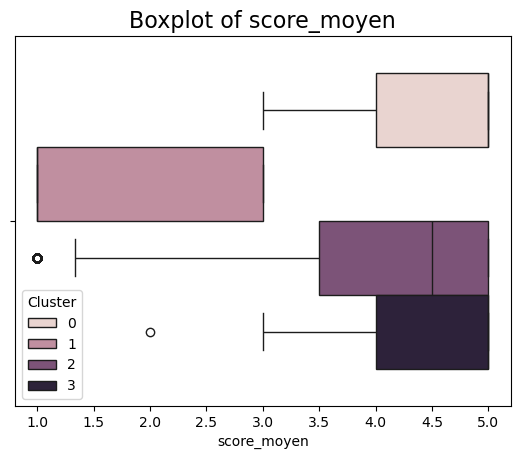

In [121]:
sns.boxplot(data=data_2_with_labels, x='score_moyen', hue='Cluster')
plt.title('Boxplot of score_moyen', fontsize=16)
plt.show()

Le cluster 2 correspond aux clients satisfaits.

**Visualisation 2D :**

Pour toutes les visualisations (hors boxplot) j'utiliserai les valeurs normalisées des features, car les figures sont plus expressives, c'est à dire que les clusters sont mieux mis en évidence.

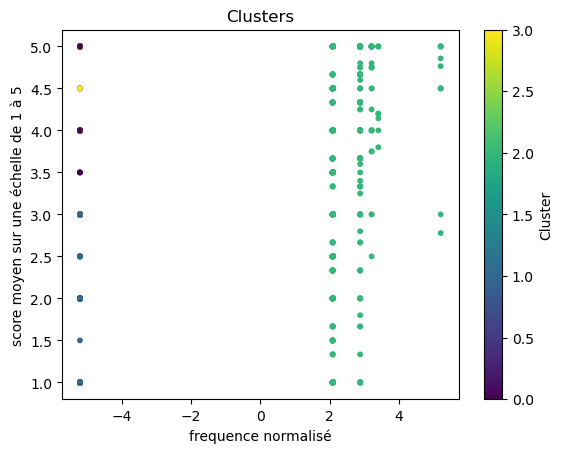

In [183]:
plt.scatter(X_2_with_labels["frequence_norm"], X_2_with_labels["score_moyen"], 
            c=X_2_with_labels["Cluster"], cmap="viridis", s=10)
plt.title("Clusters")
plt.xlabel("frequence normalisée")
plt.ylabel("score moyen sur une échelle de 1 à 5")
plt.colorbar(label="Cluster")
plt.show()

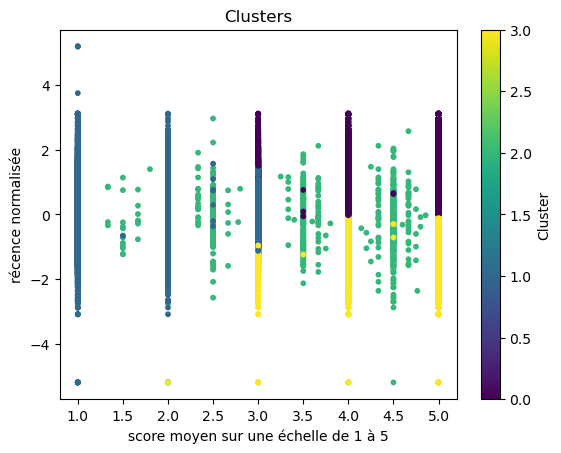

In [198]:
plt.scatter(X_2_with_labels["score_moyen"], X_2_with_labels["recence_norm"], 
            c=X_2_with_labels["Cluster"], cmap="viridis", s=10)
plt.title("Clusters")
plt.xlabel("score moyen sur une échelle de 1 à 5")
plt.ylabel("récence normalisée")
plt.colorbar(label="Cluster")
plt.show()

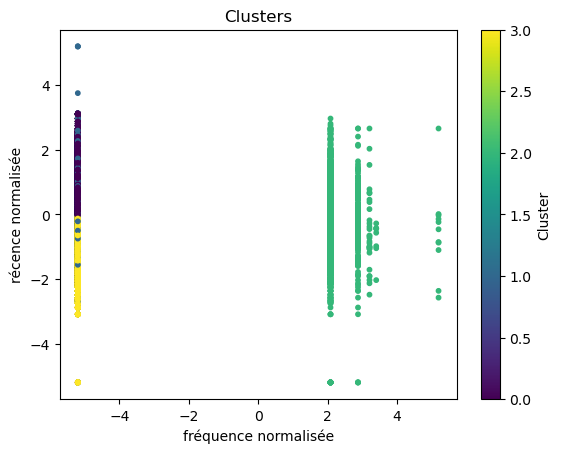

In [196]:
plt.scatter(X_2_with_labels["frequence_norm"], X_2_with_labels["recence_norm"],
            c=X_2_with_labels["Cluster"], cmap="viridis", s=10)
plt.title("Clusters")
plt.xlabel("fréquence normalisée")
plt.ylabel("récence normalisée")
plt.colorbar(label="Cluster")
plt.show()

**Visualisation 3D**

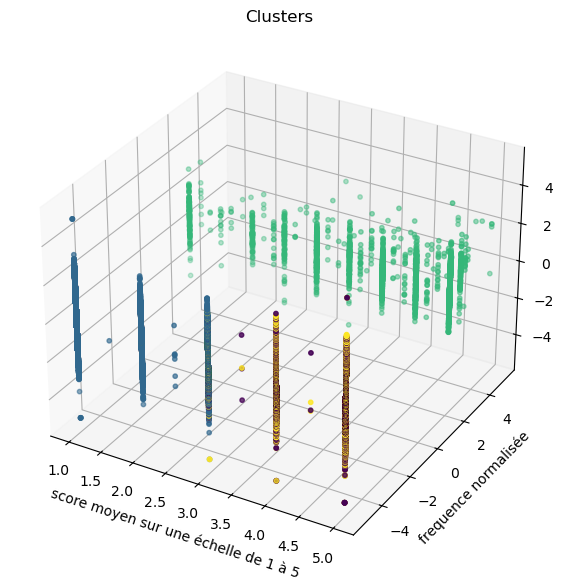

In [192]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_2_with_labels["score_moyen"], X_2_with_labels["frequence_norm"], X_2_with_labels["montant_norm"], 
           c=X_2_with_labels["Cluster"], cmap="viridis", s=10)
ax.set_title("Clusters")
ax.set_xlabel("score moyen sur une échelle de 1 à 5")
ax.set_ylabel("frequence normalisée")
ax.set_zlabel("montant normalisé")
plt.show()

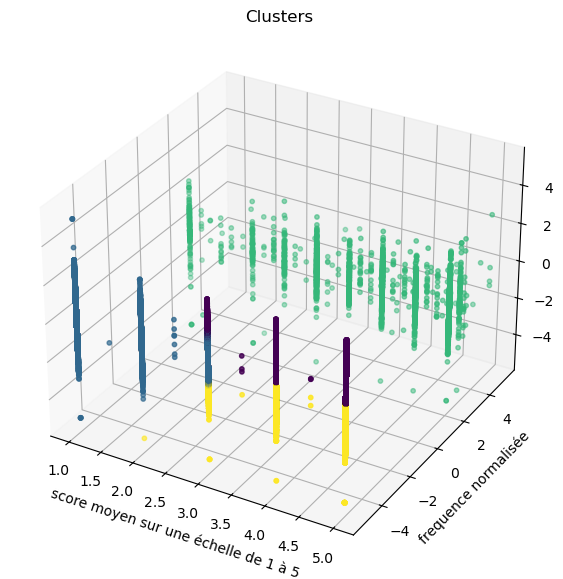

In [194]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_2_with_labels["score_moyen"], X_2_with_labels["frequence_norm"], X_2_with_labels["recence_norm"], 
           c=X_2_with_labels["Cluster"], cmap="viridis", s=10)
ax.set_title("Clusters")
ax.set_xlabel("score moyen sur une échelle de 1 à 5")
ax.set_ylabel("frequence normalisée")
ax.set_zlabel("récence normalisée")
plt.show()

On observe que :
- Le cluster vert = clients fidèles avec plusieurs commandes
- Le cluster jaune = clients récents satisfaits avec une seule commande
- Le cluster violet = cients anciens satisfaits avec une seule commande
- Le cluster bleu = clients mécontents avec une seule commande.

#### 2.5 - Visualiser le résultat du clustering avec le nombre k de clusters optimal (5) :

**Appliquons le clustering avec k-means et k = 5 :**

In [201]:
# Appliquer le clustering avec le meilleur k (par exemple, k=3)
best_k = 5  # Remplacez par le nombre optimal de clusters choisi
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_2)

# Ajouter les labels aux DataFrames
data_2_with_labels = data_2.copy()
data_2_with_labels["Cluster"] = labels

X_2_with_labels = X_2.copy()
X_2_with_labels["Cluster"] = labels

# Affichage
print(data_2_with_labels.head())

   recence  frequence  montant  score_moyen  Cluster
0       57         17   729.62     4.764706        1
1      231          9  1000.85     2.777778        1
2      245          7   809.21     5.000000        1
3      111          7   664.20     5.000000        1
4      138          7   806.61     5.000000        1


**Vérifions le nombre de clients dans les 5 clusters :**

In [203]:
mask = data_2_with_labels['Cluster'] == 0
print("Nombre de clients dans le cluster 0 :", data_2_with_labels.loc[mask].shape[0])

mask = data_2_with_labels['Cluster'] == 1
print("Nombre de clients dans le cluster 1 :", data_2_with_labels.loc[mask].shape[0])

mask = data_2_with_labels['Cluster'] == 2
print("Nombre de clients dans le cluster 2 :", data_2_with_labels.loc[mask].shape[0])

mask = data_2_with_labels['Cluster'] == 3
print("Nombre de clients dans le cluster 3 :", data_2_with_labels.loc[mask].shape[0])

mask = data_2_with_labels['Cluster'] == 4
print("Nombre de clients dans le cluster 4 :", data_2_with_labels.loc[mask].shape[0])

Nombre de clients dans le cluster 0 : 23678
Nombre de clients dans le cluster 1 : 2997
Nombre de clients dans le cluster 2 : 17098
Nombre de clients dans le cluster 3 : 26776
Nombre de clients dans le cluster 4 : 25547


**Calculons les moyennes par cluster:**

In [205]:
means = []
for cluster in data_2_with_labels['Cluster'].unique():
    mask = data_2_with_labels['Cluster'] == cluster
    means.append([cluster, data_2_with_labels.loc[mask, 'recence'].mean(), \
                  data_2_with_labels.loc[mask, 'frequence'].mean(), \
                  data_2_with_labels.loc[mask, 'montant'].mean(), \
                  data_2_with_labels.loc[mask, 'score_moyen'].mean()])
df_means = pd.DataFrame(data=means, columns=['cluster', 'recence moy', 'frequence moy', 'montant moy', 'score_moyen moy'])
df_means.head()

,cluster,recence moy,frequence moy,montant moy,score_moyen moy
0,1,268.206874,2.116116,260.107164,4.118883
1,4,135.484832,1.000000,74.200819,4.674502
2,3,416.608045,1.000000,56.007063,4.624589
3,0,305.624842,1.000000,293.193542,4.668870
4,2,292.052872,1.000000,148.285459,1.582934


On observe que :
- le cluster 0 contient les clients fidèles avec plusieurs commandes.
- le cluster 4 contient les clients récents satisfaits, avec une seule commande.
- le cluster 3 contient les clients anciens satisfaits avec une seule commande, et une dépense faible.
- le cluster 0 contient des clients anciens satisfaits avec une seule commande, et une dépense élevée.
- le cluster 2 contient les clients non satisfaits avec une seule commande.

*Les 4 features semblent intervenir dans la détermination des 5 clusters.*

**Visualisons les boxplots de chaque feature par cluster**

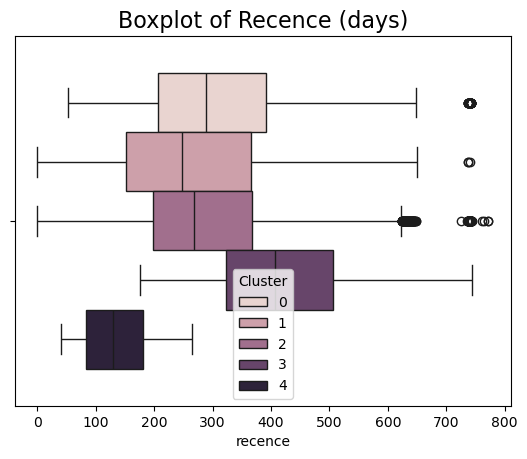

In [209]:
sns.boxplot(data=data_2_with_labels, x='recence', hue='Cluster')
plt.title('Boxplot of Recence (days)', fontsize=16)
plt.show()

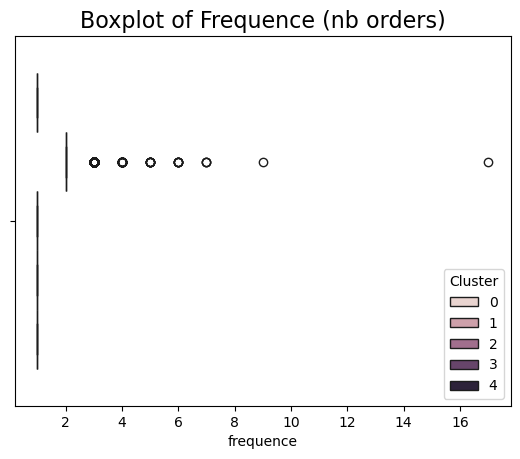

In [211]:
sns.boxplot(data=data_2_with_labels, x='frequence', hue='Cluster')
plt.title('Boxplot of Frequence (nb orders)', fontsize=16)
plt.show()

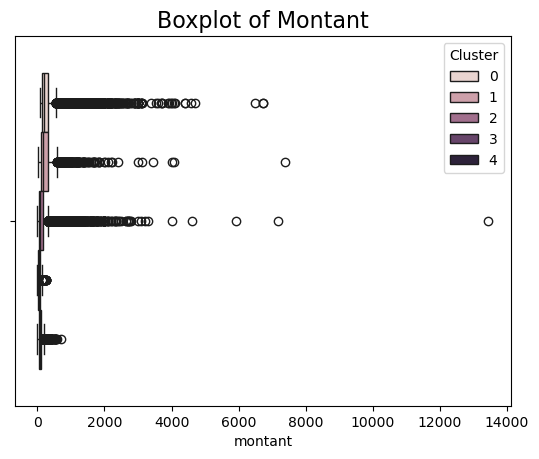

In [213]:
sns.boxplot(data=data_2_with_labels, x='montant', hue='Cluster')
plt.title('Boxplot of Montant', fontsize=16)
plt.show()

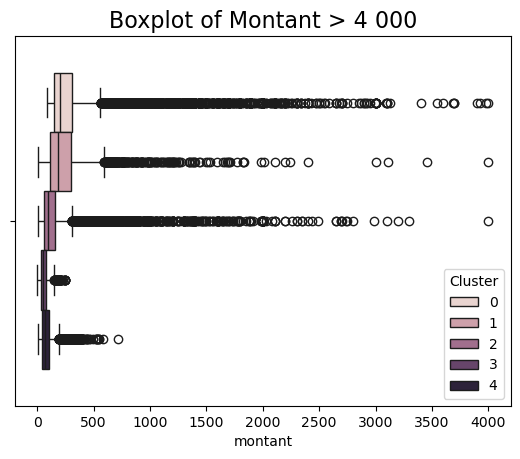

In [215]:
mask = data_2_with_labels['montant'] < 4000
sns.boxplot(data=data_2_with_labels.loc[mask], x='montant', hue='Cluster')
plt.title('Boxplot of Montant > 4 000', fontsize=16)
plt.show()

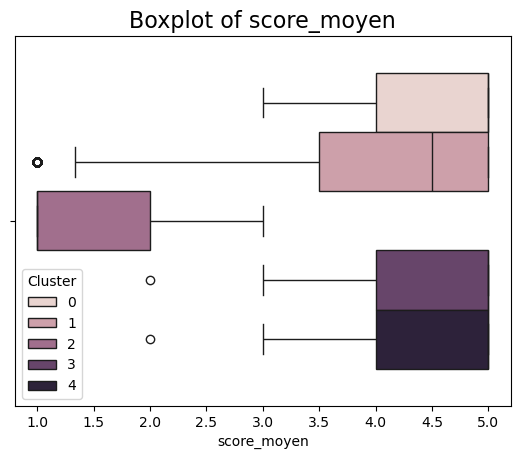

In [217]:
sns.boxplot(data=data_2_with_labels, x='score_moyen', hue='Cluster')
plt.title('Boxplot of score_moyen', fontsize=16)
plt.show()

Sur les boxplots, on se rend compte de l'intervention des 4 features dans la détermination des clusters.

**Visualisations 2D et 3D**

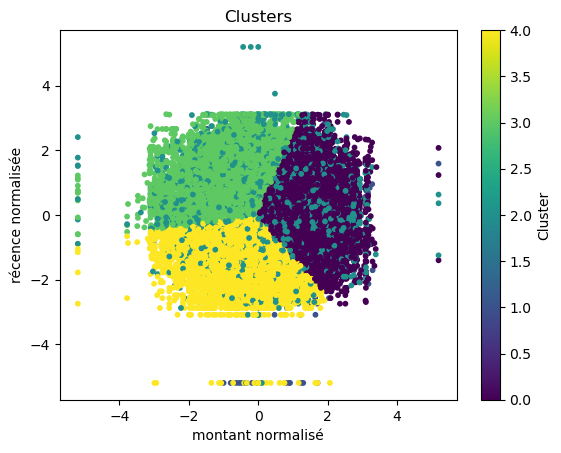

In [222]:
plt.scatter(X_2_with_labels["montant_norm"], X_2_with_labels["recence_norm"],
            c=X_2_with_labels["Cluster"], cmap="viridis", s=10)
plt.title("Clusters")
plt.xlabel("montant normalisé")
plt.ylabel("récence normalisée")
plt.colorbar(label="Cluster")
plt.show()

3 clusters se distinguent :
- jaune = clients récents à faibles dépenses
- vert = clients anciens à faibles dépenses
- violet = clients à dépenses élevées

Les 2 autres clusters sont diffus, ce qui signale l'importance d'une ou plusieurs features pourd éterminer ces 2 clusters.

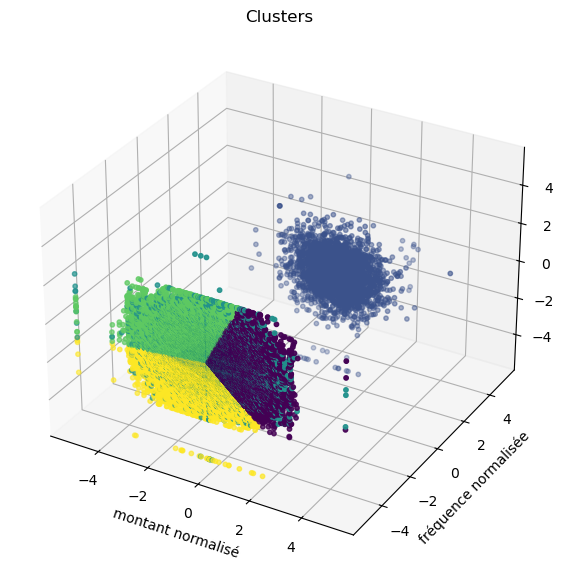

In [230]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_2_with_labels["montant_norm"], X_2_with_labels["frequence_norm"], X_2_with_labels["recence_norm"], 
           c=X_2_with_labels["Cluster"], cmap="viridis", s=10)
ax.set_title("Clusters")
ax.set_xlabel("montant normalisé")
ax.set_ylabel("fréquence normalisée")
ax.set_zlabel("récence normalisée")
plt.show()

On voit maintenant apparaître le cluster bleu des clients fidèles (avec plusieurs commandes) dans le fond.

Il manque le cluster bleu-vert. Cherchons à le visualiser :

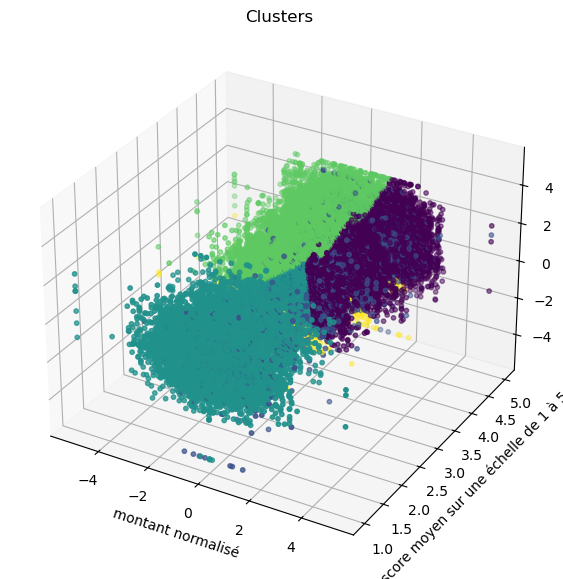

In [233]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_2_with_labels["montant_norm"], X_2_with_labels["score_moyen"], X_2_with_labels["recence_norm"], 
           c=X_2_with_labels["Cluster"], cmap="viridis", s=10)
ax.set_title("Clusters")
ax.set_xlabel("montant normalisé")
ax.set_ylabel("score moyen sur une échelle de 1 à 5")
ax.set_zlabel("récence normalisée")
plt.show()

Il apparait ici, mais de façon floue. On voit que le montant n'intervient pas dans sa détermination.

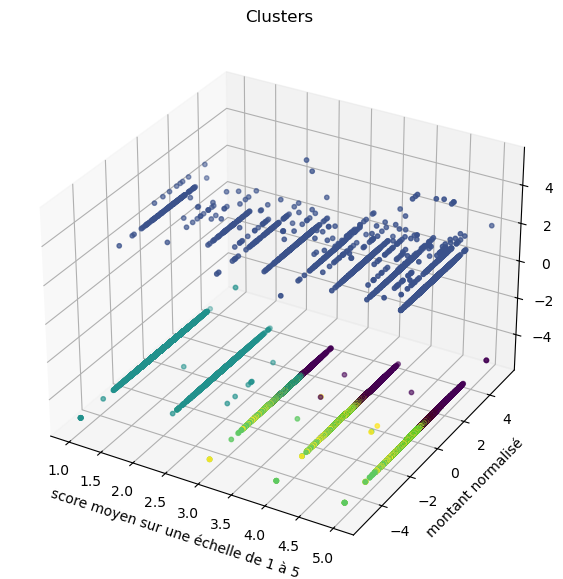

In [241]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_2_with_labels["score_moyen"], X_2_with_labels["montant_norm"], X_2_with_labels["frequence_norm"], 
           c=X_2_with_labels["Cluster"], cmap="viridis", s=10)
ax.set_title("Clusters")
ax.set_xlabel("score moyen sur une échelle de 1 à 5")
ax.set_ylabel("montant normalisé")
ax.set_zlabel("fréquence normalisée")
plt.show()

Le dernier cluster apparaît ici en bas à gauche avec les caractéristiques clients suivantes :
- une seule commande
- mécontents
- quelque soit le montant dépensé